In [1]:
# 首先我们来统计论文页数，也就是在comments字段中抽取pages和figures和个数，首先完成字段读取。
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

In [2]:
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'], count=None):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
    '''
    
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            d = {col : d[col] for col in columns}
            data.append(d)

    data = pd.DataFrame(data)
    return data

data = readArxivFile('arxiv-metadata-oai-snapshot.json', ['id', 'abstract', 'categories', 'comments'])


In [3]:
# 对pages进行抽取：
# 使用正则表达式匹配，XX pages
data['pages'] = data['comments'].apply(lambda x: re.findall('[1-9][0-9]* pages', str(x)))

# 筛选出有pages的论文
data = data[data['pages'].apply(len) > 0]

# 由于匹配得到的是一个list，如['19 pages']，需要进行转换
data['pages'] = data['pages'].apply(lambda x: float(x[0].replace(' pages', '')))

In [4]:
# 对pages进行统计，统计结果如下：论文平均的页数为17页，75%的论文在22页以内，最长的论文有11232页。
data['pages'].describe().astype(int)

count    1089180
mean          17
std           22
min            1
25%            8
50%           13
75%           22
max        11232
Name: pages, dtype: int64

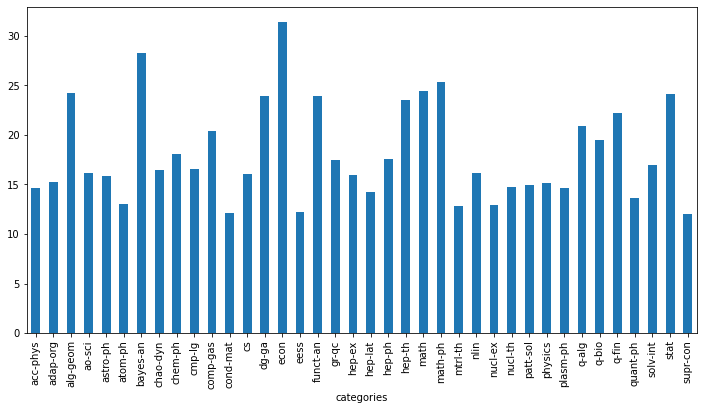

In [5]:
# 接下来按照分类统计论文页数，选取了论文的第一个类别的主要类别：
# 选择主要类别
data['categories'] = data['categories'].apply(lambda x: x.split(' ')[0])
data['categories'] = data['categories'].apply(lambda x: x.split('.')[0])

# 每类论文的平均页数
plt.figure(figsize=(12, 6))
data.groupby(['categories'])['pages'].mean().plot(kind='bar')


In [6]:
# 接下来对论文图表个数进行抽取：
data['figures'] = data['comments'].apply(lambda x: re.findall('[1-9][0-9]* figures', str(x)))
data = data[data['figures'].apply(len) > 0]
data['figures'] = data['figures'].apply(lambda x: float(x[0].replace(' figures', '')))

In [7]:
# 最后我们对论文的代码链接进行提取，为了简化任务我们只抽取github链接：
# 筛选包含github的论文
data_with_code = data[
    (data.comments.str.contains('github')==True)|
                      (data.abstract.str.contains('github')==True)
]
data_with_code['text'] = data_with_code['abstract'].fillna('') + data_with_code['comments'].fillna('')

# 使用正则表达式匹配论文
pattern = '[a-zA-z]+://github[^\s]*'
data_with_code['code_flag'] = data_with_code['text'].str.findall(pattern).apply(len)

<ipython-input-7-402562aac5f0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_code['text'] = data_with_code['abstract'].fillna('') + data_with_code['comments'].fillna('')
<ipython-input-7-402562aac5f0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_code['code_flag'] = data_with_code['text'].str.findall(pattern).apply(len)


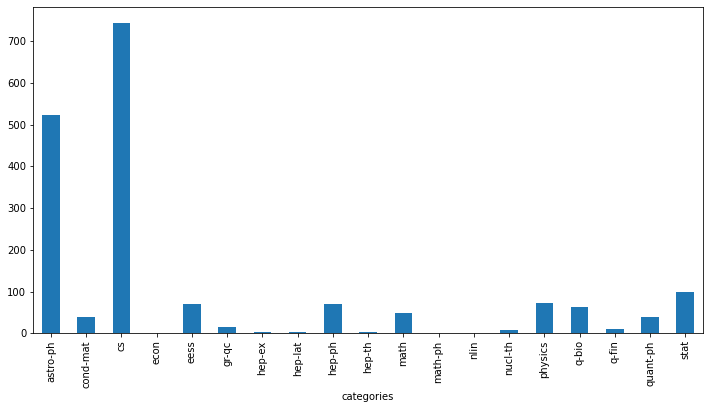

In [8]:
# 并对论文按照类别进行绘图：
data_with_code = data_with_code[data_with_code['code_flag'] == 1]
plt.figure(figsize=(12, 6))
data_with_code.groupby(['categories'])['code_flag'].count().plot(kind='bar')

In [12]:
data.head()


,id,abstract,categories,comments,pages,figures
0,0704.0001,A fully differential calculation in perturba...,hep-ph,"37 pages, 15 figures; published version",37.0,15.0
2,0704.0003,The evolution of Earth-Moon system is descri...,physics,"23 pages, 3 figures",23.0,3.0
5,0704.0006,We study the two-particle wave function of p...,cond-mat,"6 pages, 4 figures, accepted by PRA",6.0,4.0
9,0704.0010,Partial cubes are isometric subgraphs of hyp...,math,"36 pages, 17 figures",36.0,17.0
15,0704.0016,"In this work, we evaluate the lifetimes of t...",hep-ph,"17 pages, 3 figures and 1 table",17.0,3.0


In [13]:
data_with_code.to_csv('data_with_code.csv', index=None)